In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import re

from datetime import datetime
now = datetime.now()
date = now.strftime("%d%b%Y")

pd.set_option('display.max_columns',None) 
pd.set_option('display.max_colwidth', None)


# from io import StringIO
# import csv

# nmrview .xpk files are nonstandard formatting with some columns in brackets
# otherwise space deliminated 
# bracketed columns: *.J *.U *.L comment

###### Functions
def read_xpk(file, header_lines=5,strip=True,sort=True):
    raw=pd.DataFrame()
    with open(file) as fp:
        for i, line in enumerate(fp):
            #Assuming header_lines is correct, convert that line to the column values
            if i == header_lines:
                xpk_columns = ['pk']+line.rstrip().replace('\t',' ').split(' ')
                raw = pd.DataFrame(columns=xpk_columns)
            #otherwise, get the data after the column names
            #break lines up to capture any curly bracketed content as a single cell entry
            #this retains the curly brackets so output matches what an xpk text file looks like
            elif (i > header_lines):                
                breaks = [0]
                for j,v in enumerate(line):
                    if v == "{":
                        breaks += [j]
                    if v == "}":
                        breaks += [j+1]
                breaks += [len(line)]

                items = []
                for k in range(len(breaks)-1):
                    item=line[breaks[k]:breaks[k+1]]
                    if item[0] == "{":
                        items.append(item)
                    else: 
                        for j,v in enumerate(item.split()):
                            items.append(v)
                #print (items)             
                raw.loc[len(raw)]=items
    if strip:
        raw = raw.replace('{|}','',regex=True)
    if sort:
        label_columns = [l for l in raw.columns if ".L" in l]
        raw['res'] = raw[label_columns[0]].str.extract('(\d+)').astype('Int64') #get res from first .L
        raw = raw.sort_values(by = ['res'])

    return raw

def get_ddhnavg(data,scale_n = 5.0,samples=None,reference=None,uselabel='HN'):
    if samples == None:
        samples = list(data['sample'].unique())
    if reference == None:
        reference = samples[0]
    samples = [reference] + [x for x in samples if x is not reference]
    label = 'HN.L' if uselabel in ['HN','hn','h'] else '15N.L'
    ref_residues = list(data[label][data['sample']==reference].unique())
    if '' in ref_residues: ref_residues.remove('')
    #ref_residues.sort()
    csps = pd.DataFrame()
    csps['residue']=ref_residues
    csps['resid']=[x.split('.')[0] for x in csps['residue']]
    csps['resid']=csps['resid'].astype(int)
    for i,sample in enumerate(samples):
        df = data.copy()[data['sample']==sample]
        hdict = dict([(i,x) for i,x in zip(df[label], df['HN.P'])])
        ndict = dict([(i,x) for i,x in zip(df[label], df['15N.P'])])
        csps['HN_'+str(i)]=csps.get('HN_'+str(i),csps['residue'].map(hdict)).astype(np.float16)
        csps['N_'+str(i)]=csps.get('N_'+str(i),csps['residue'].map(ndict)).astype(np.float16)
    for i in range(1,len(samples)):
        csps['ddHN_'+str(i)] = csps['HN_'+str(i)]-csps['HN_0']
        csps['ddN_'+str(i)] = csps['N_'+str(i)]-csps['N_0']
        csps['ddHNavg_'+str(i)]=np.sqrt(csps['ddHN_'+str(i)]**2 + (csps['ddN_'+str(i)]/scale_n)**2)
    csps = csps.sort_values(by=['resid','residue'],ascending=[True,False],ignore_index=True)
    return samples, csps


def rename_HN(row):

    if '.' in row['HN.L']:
        resi, suffix = row['HN.L'].split('.')
    else:
        resi = row['HN.L']
        if len(resi)>0: suffix = 'unk'
        else: suffix = ''

    if any(echar in suffix for echar in ['E','e']):
        suffix = 'HE1'
    elif any(hchar in suffix for hchar in ['hn','H','HN','hn','h']):
        suffix = 'HN'
    else: suffix = suffix
    if len(resi)>0:
        new_label = resi+'.'+suffix
    else: new_label = ''

    return new_label


######## end Functions




In [2]:
#Get the data
Header_Lines = 5
project_dir = os.getcwd()

xpk_files = [ f for f in os.listdir(project_dir) if f[-4:]=='.xpk'  ]
samples = [ff[:-4] for ff in xpk_files] 

# this will join all xpk file data in the project_dir into one dataframe 
# works even if mixed dimensions (e.g. HSQCs + HNCACB)
all_xpks = pd.DataFrame()
for file in xpk_files:
    test_xpk = read_xpk(os.path.join(project_dir,file),header_lines=Header_Lines)
    test_xpk['sample']=file[:-4]
    all_xpks = pd.concat([all_xpks,test_xpk], ignore_index=True,axis=0)

#to remove curly brackets from entries 
all_xpks = all_xpks.replace('{|}','',regex=True)
all_xpks['HN.L'] = all_xpks.apply(rename_HN,axis=1) #unify label names for matching 

In [4]:
samples = all_xpks['sample'].unique()
ntohn_scale = 5.0
hn = {}
n, n_scaled = {}, {}
X, X_scaled = {}, {}
all_xpks['15N.P_scaled'] = all_xpks['15N.P'].astype(float)/ntohn_scale
for sample in samples:
    X[sample] = all_xpks[all_xpks['sample']==sample][['HN.P','15N.P']].astype(float).to_numpy(copy=True)
    X_scaled[sample] =  all_xpks[all_xpks['sample']==sample][['HN.P','15N.P_scaled']].astype(float).to_numpy(copy=True)
    hn[sample] = all_xpks[all_xpks['sample']==sample]['HN.P'].astype(float).to_numpy(copy=True)
    n[sample] = all_xpks[all_xpks['sample']==sample]['15N.P'].astype(float).to_numpy(copy=True)
    n_scaled[sample] = n[sample]/ntohn_scale
    

In [5]:
#from collections import defaultdict # = defaultdict(dict)
import scipy.spatial
from scipy.optimize import linear_sum_assignment

#samples = all_xpks['sample'].unique()
samples = ['WT','L34A','L34K', 'R60P', 'V27CL34C', 'WT_Mannose', 'L34A_Mannose', 'L34K_Mannose','R60P_Mannose','V27CL34C_Mannose']

D,D_scaled = {}, {}
score = {}
avg_score = {}
score_scaled = {}
avg_score_scaled = {}
num_missing = {}
row_ind, col_ind = {}, {}
score2d = []
avg_score2d = []

avg_score_scaled_penalized = {}
penalty_2d = []
penalty = 0.5

missing2d = []

for ref in samples:
    score_row = []
    avg_score_row = []
    missing_row = []
    penalty_row = []
    for sample in samples:
        k = sample+'_vs_'+ref
        num_missing[k] = len(X[ref]) - len(X[sample])
        min_peaks = min(len(X[ref]),len(X[sample]))
        max_peaks = max(len(X[ref]),len(X[sample]))

        D[k] = scipy.spatial.distance.cdist(X[ref],X[sample],metric='euclidean')
        row_ind[k], col_ind[k] = linear_sum_assignment(D[k])
        score[k] = D[k][row_ind[k], col_ind[k]].sum()
        avg_score[k] = (D[k][row_ind[k], col_ind[k]]).mean()

        D_scaled[k] = scipy.spatial.distance.cdist(X_scaled[ref],X_scaled[sample],metric='euclidean')
        row_ind[k], col_ind[k] = linear_sum_assignment(D_scaled[k])
        score_scaled[k] = D_scaled[k][row_ind[k], col_ind[k]].sum()
        avg_score_scaled[k] = (D_scaled[k][row_ind[k], col_ind[k]]).mean()

        #avg_score_scaled_penalized[k] = avg_score_scaled[k] + penalty*np.abs(num_missing[k])/min(len(X[ref]),len(X[sample]))
        avg_score_scaled_penalized[k] = avg_score_scaled[k]*min_peaks/max_peaks + penalty * (max_peaks - min_peaks)/max_peaks
        # sum is score * num_peaks ... avg * min_peaks + 0.5ppm * #missing/max_peaks

        score_row += [score_scaled[k]]
        avg_score_row += [avg_score_scaled[k]]
        missing_row += [num_missing[k]]
        penalty_row += [avg_score_scaled_penalized[k]]
    score2d += [score_row]
    avg_score2d += [avg_score_row]
    missing2d += [missing_row]
    penalty_2d += [penalty_row]
    
score2d = np.array(score2d)
avg_score2d = np.array(avg_score2d)
missing2d = np.array(missing2d)
penalty_2d = np.array(penalty_2d)


In [6]:
#get csps from assignments 

all_csps={}
samp={}
sum_csp={}
avg_csp={}
avg_csp_penalty={}
csp_penalty = 0.5 #ppm
for ref in samples:
    all_csps[ref] = pd.DataFrame()
    samp[ref],all_csps[ref] = get_ddhnavg(all_xpks,samples=samples,reference=ref)
    npks_ref = len(all_xpks[(all_xpks['sample']==ref) & (all_xpks['HN.L'].str.contains('.H'))]['HN.L'].unique())
    #print(ref, samp)
    for n,s in enumerate(samp[ref]):
        npks_comp = len(all_xpks[(all_xpks['sample']==s) & (all_xpks['HN.L'].str.contains('.H'))]['HN.L'].unique())
        if len(all_csps[ref]) == 0:
            sumcsp = np.nan
            avgcsp = np.nan
            avgcsp_penalty = np.nan        
        else: 
            try: 
                sumcsp = all_csps[ref]['ddHNavg_'+str(n)].sum()
                avgcsp = all_csps[ref]['ddHNavg_'+str(n)].mean()
                avgcsp_penalty = sumcsp + csp_penalty * abs(npks_ref - npks_comp)
                avgcsp_penalty = avgcsp_penalty/max(npks_comp,npks_ref)           
                if len(all_csps[ref]['ddHNavg_'+str(n)]) == all_csps[ref]['ddHNavg_'+str(n)].isna().sum():
                    sumcsp = np.nan
                    avgcsp = np.nan
                    avgcsp_penalty = np.nan
            except: 
                sumcsp=0
                avgcsp=0
                avgcsp_penalty=0
        #print(s+'_vs_'+ref)
        sum_csp[s+'_vs_'+ref] = sumcsp
        avg_csp[s+'_vs_'+ref] = avgcsp
        avg_csp_penalty[s+'_vs_'+ref] = avgcsp_penalty

csp_2d = []
csp_avg_2d = []
csp_avg_penalty_2d =[]
for ref in samples: #compare_xpks:
    csp_row = []
    csp_avg_row = []
    csp_pen_row = []
    for s in samples:       
        k = s+'_vs_'+ref        
        csp_row += [sum_csp[k]]
        csp_avg_row += [avg_csp[k]]
        csp_pen_row += [avg_csp_penalty[k]]
        #print(k)
    #print(csp_row)
    csp_2d += [csp_row]  
    csp_avg_2d += [csp_avg_row]
    csp_avg_penalty_2d += [csp_pen_row]
csp_2d = np.array(csp_2d)
csp_avg_2d = np.array(csp_avg_2d)
csp_avg_penalty_2d = np.array(csp_avg_penalty_2d)


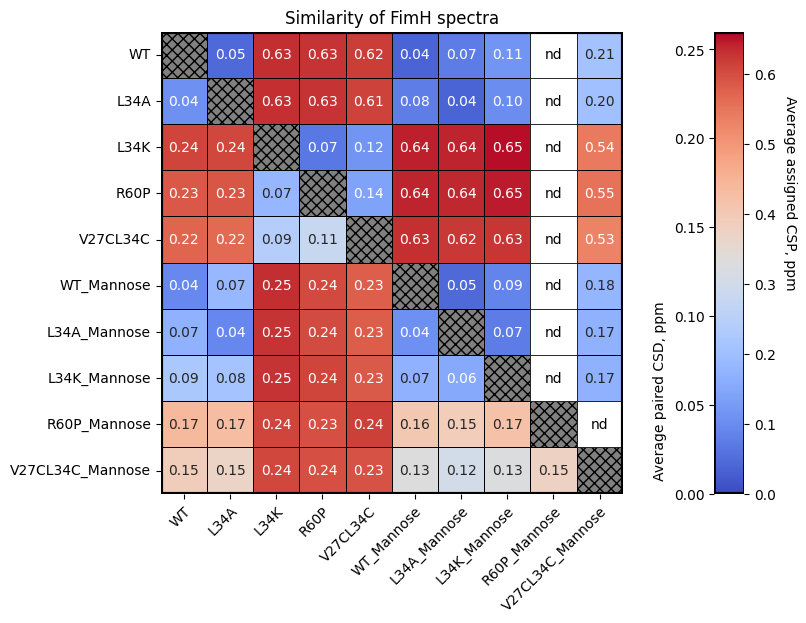

In [7]:
# try with penalty applied

import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as patches

#sns.set_theme(style="white")

corr1 = csp_avg_penalty_2d #csp_avg_2d #np.nan_to_num(csp_avg_2d,copy=True,nan=0)
corr2 = penalty_2d #avg_score2d
mask1 = np.tril(np.ones_like(corr1, dtype=bool))
mask2 = np.triu(np.ones_like(corr2, dtype=bool))

fig, ax = plt.subplots(figsize=(6, 6),)#ncols=2,gridspec_kw={'width_ratios':[20,1],},)
cax = fig.add_axes([1.05, 0.11, .05, 0.77])
cax1 = fig.add_axes([1.05, 0.11, .05, 0.77])

vmax = round(np.nanmax(corr2,),2)+.01
vmax1 = round(np.nanmax(corr1),2)+.01
#vmax = max(vmax,vmax1)

sns.heatmap(corr2, mask=mask2, cmap='coolwarm', annot=True, fmt='.2f',linewidths=0.5, linecolor='k',
            square=True,   ax=ax,cbar_ax=cax,cbar_kws={"pad":-10.0}, vmin=0,vmax=vmax)
sns.heatmap(corr1, mask=mask1, cmap='coolwarm', annot=True, fmt='.2f',linewidths=0.5, linecolor='k',
            square=True,   ax=ax,vmin=0,vmax=vmax1,cbar_ax=cax1,cbar_kws={"pad":-10.0},)  


# Rotate the tick labels and set their alignment.

plt.setp(ax.get_yticklabels(), rotation=0, ha="right", rotation_mode="anchor")
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
#cax.set_ylabel("Assigned ←     Average CSP, ppm     → Paired",rotation=-90,labelpad=15)
cax.yaxis.tick_left()
cax.yaxis.set_label_position("left")
cax.set_ylabel("   Average paired CSD, ppm",rotation=90,labelpad=5,loc='bottom')
cax.axvline(x=0, color='k',linewidth=2)
cax.axvline(x=vmax-0.00, color='k',linewidth=2)
cax.axhline(y=0,color='k',linewidth=3)
cax.axhline(y=vmax,color='k',linewidth=3)
cax1.set_ylabel("Average assigned CSP, ppm                                ",rotation=-90,labelpad=15,loc='center')
cax1.axvline(x=0, color='k',linewidth=2)
cax1.axvline(x=vmax1-0.00, color='k',linewidth=2)
cax1.axhline(y=0,color='k',linewidth=3)
cax1.axhline(y=vmax1,color='k',linewidth=3)

ax.set_xticklabels(samples)
ax.set_yticklabels(samples)

ax.patch.set_facecolor('grey')  
ax.patch.set_edgecolor('black')
ax.patch.set_hatch('xxx')

ax.axhline(y=0, color='k',linewidth=3)
ax.axhline(y=corr1.shape[1], color='k',linewidth=3)
ax.axvline(x=0, color='k',linewidth=3)
ax.axvline(x=corr1.shape[0], color='k',linewidth=3)

ax.set_title("Similarity of FimH spectra")

#find na values in original data and white them out, add 'nd' text
#currently just applied to the assigned CSPs since paired shouldn't be missing
for y,x in np.argwhere(np.isnan(np.ma.masked_where(mask1,corr1))):
    ax.add_patch(
        patches.Rectangle(
            (x, y),1.0,1.0,
            edgecolor='k',facecolor='white', lw=0.5 ) );
    ax.text(x+.5,y+.5,'nd',ha="center",va="center")    


#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
plt.show()



#filename = 'FimH_ALL_Similarity_Heatmap_paired_missing_penalized0p5ppm_vs_assigned_maintext_'+date
# filename = 'FimH_ALL_Similarity_Heatmap_paired_missing_penalized0p5ppm_vs_assigned_suppinfo_'+date
# fig.savefig(os.path.join(project_dir,filename+'.svg'),format='svg',bbox_inches='tight')
# fig.savefig(os.path.join(project_dir,filename+'.pdf'),format='pdf',dpi=600,bbox_inches='tight')

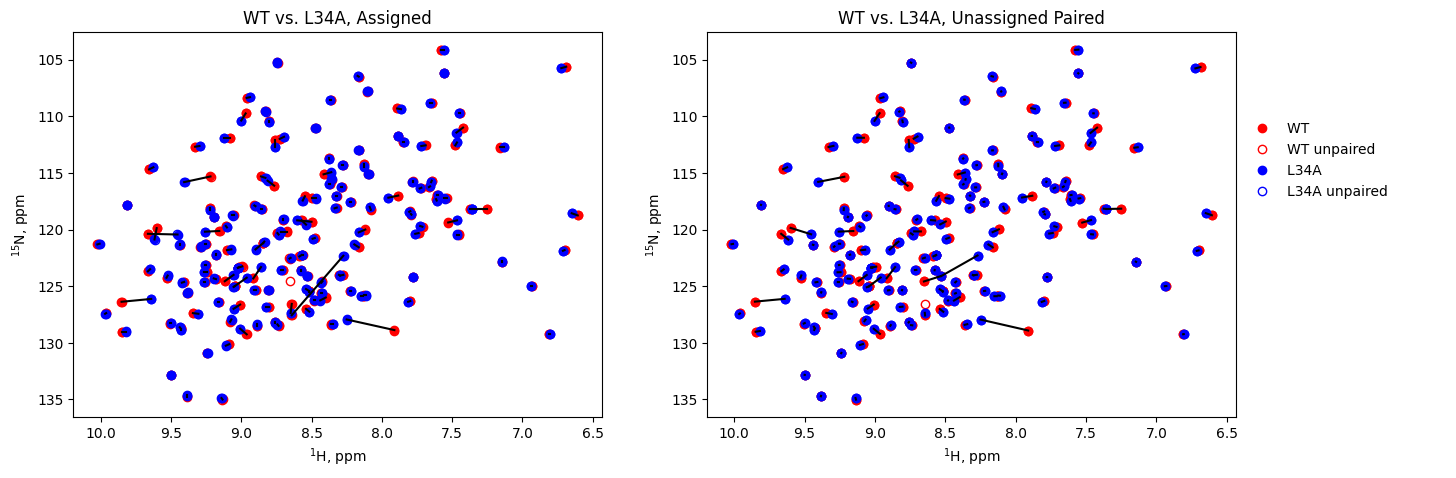

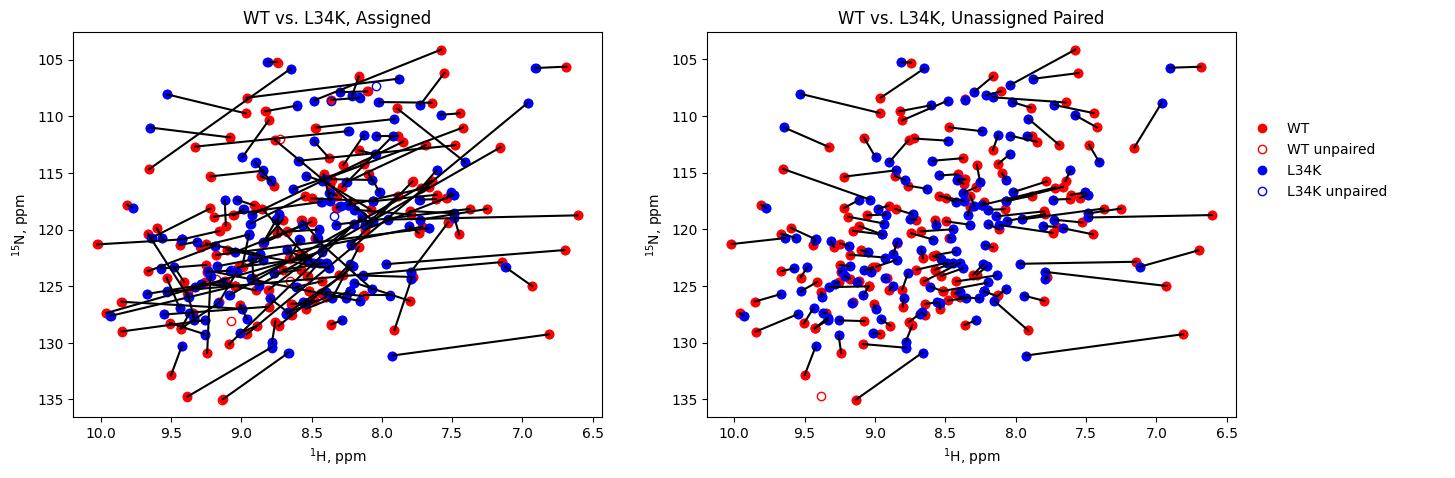

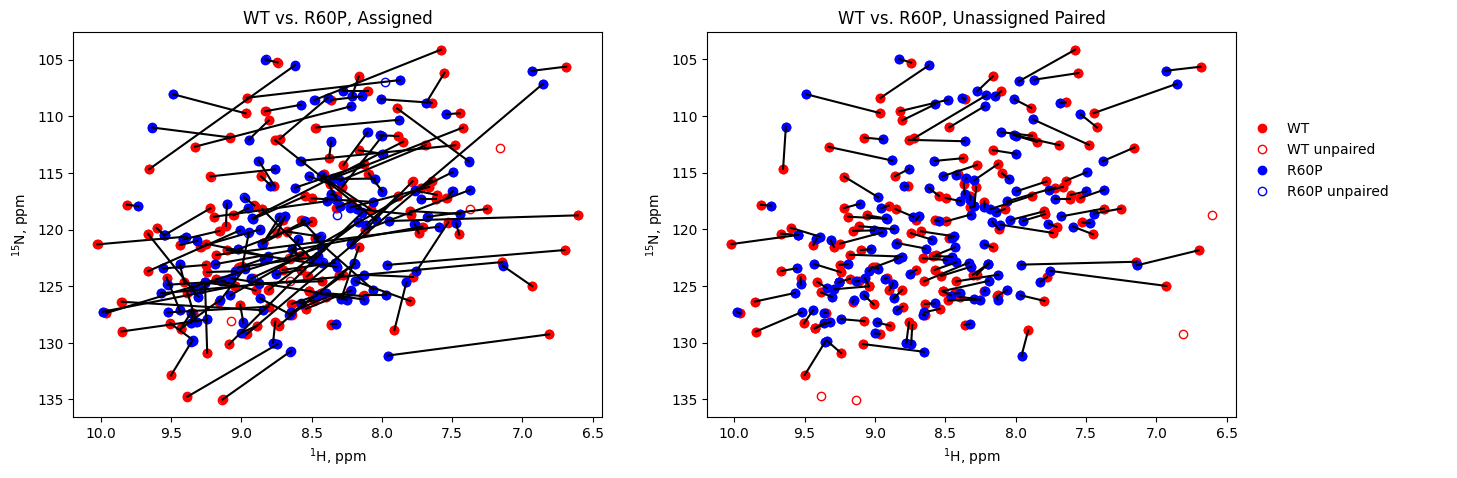

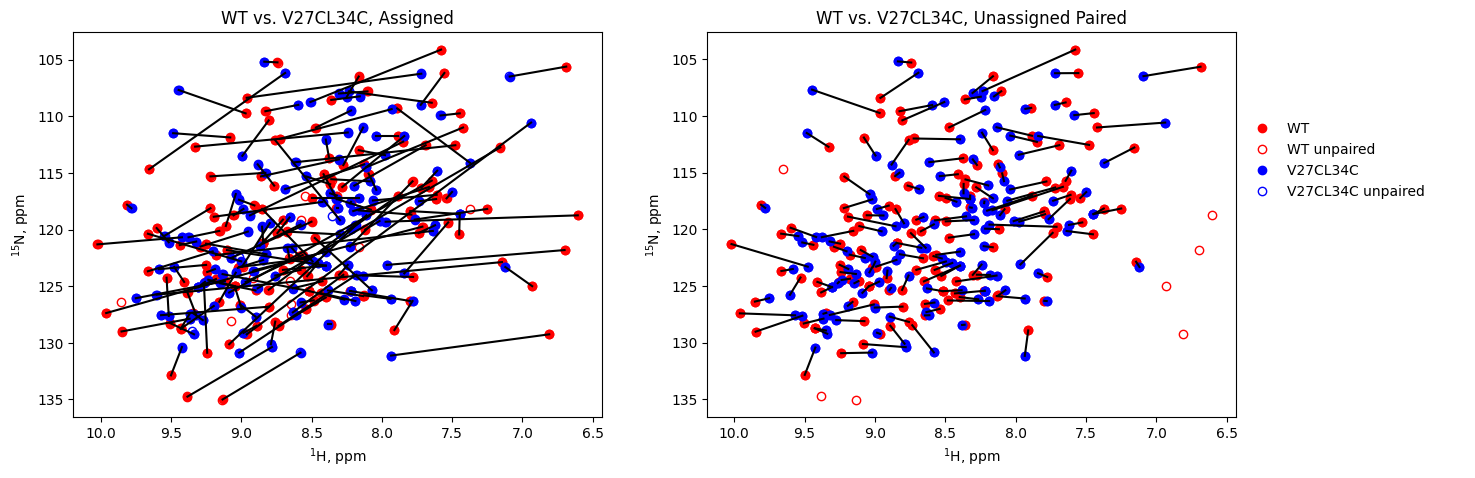

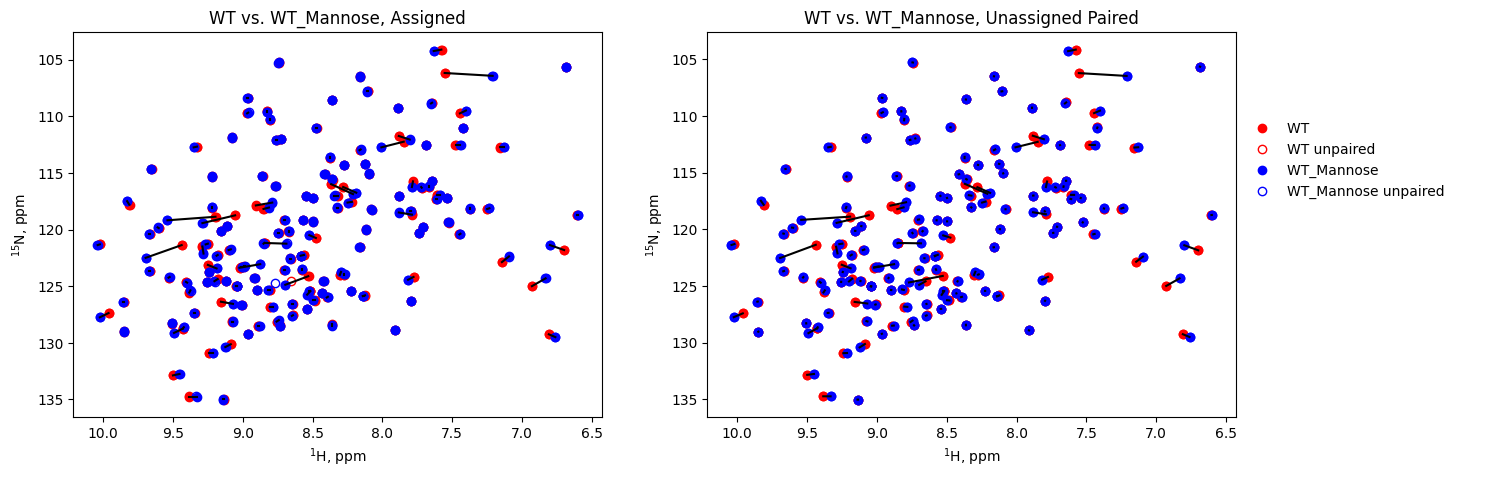

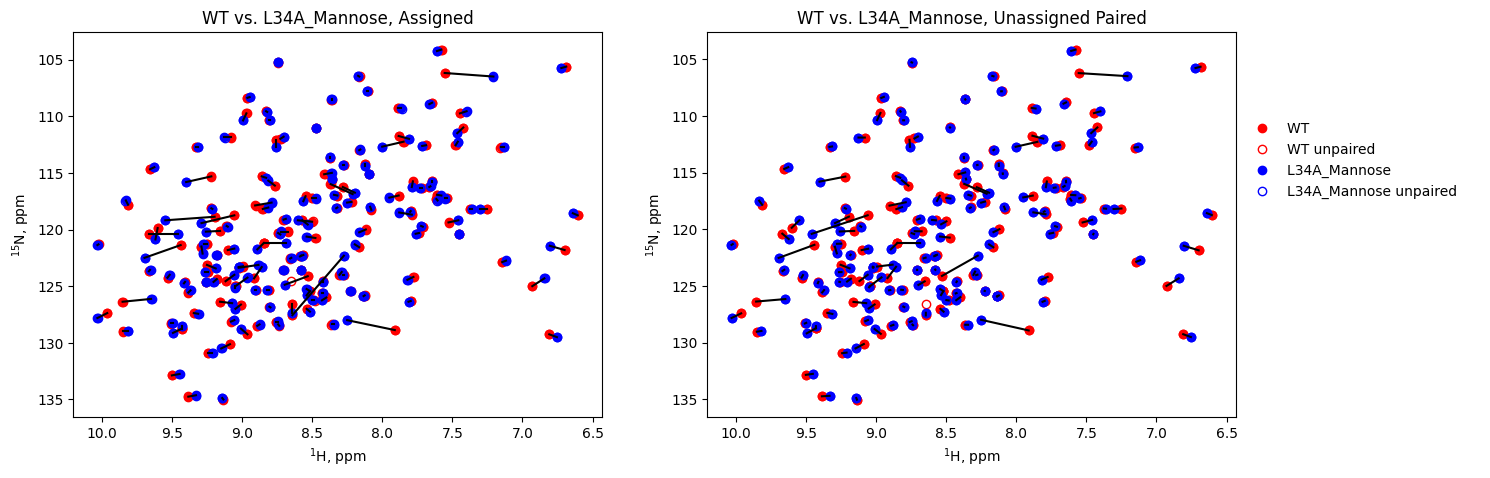

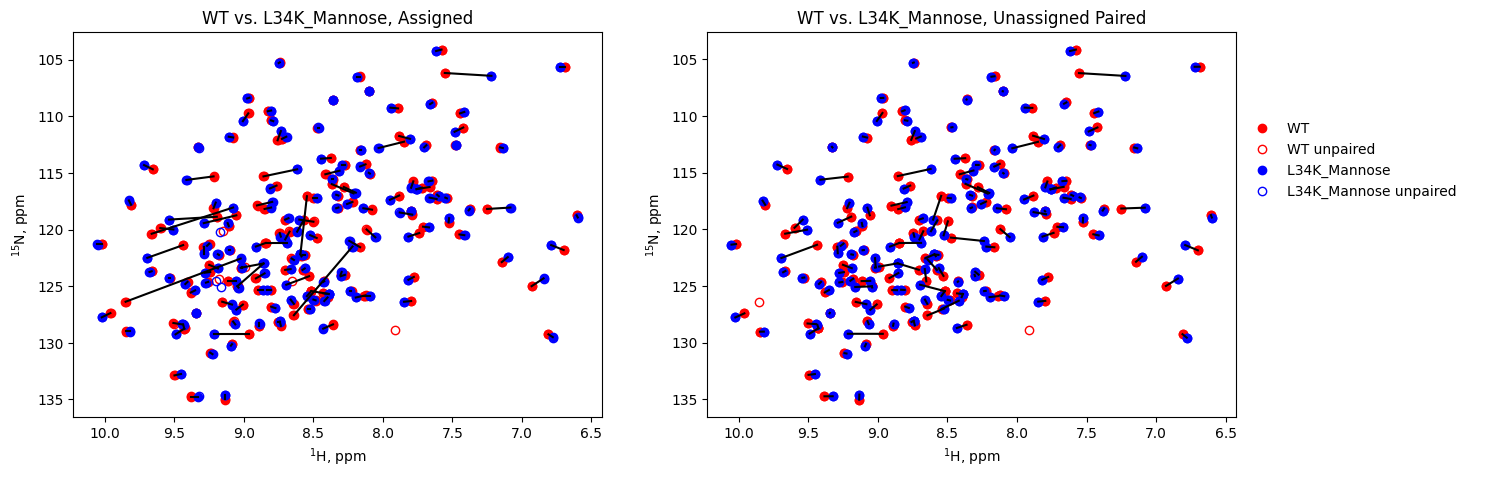

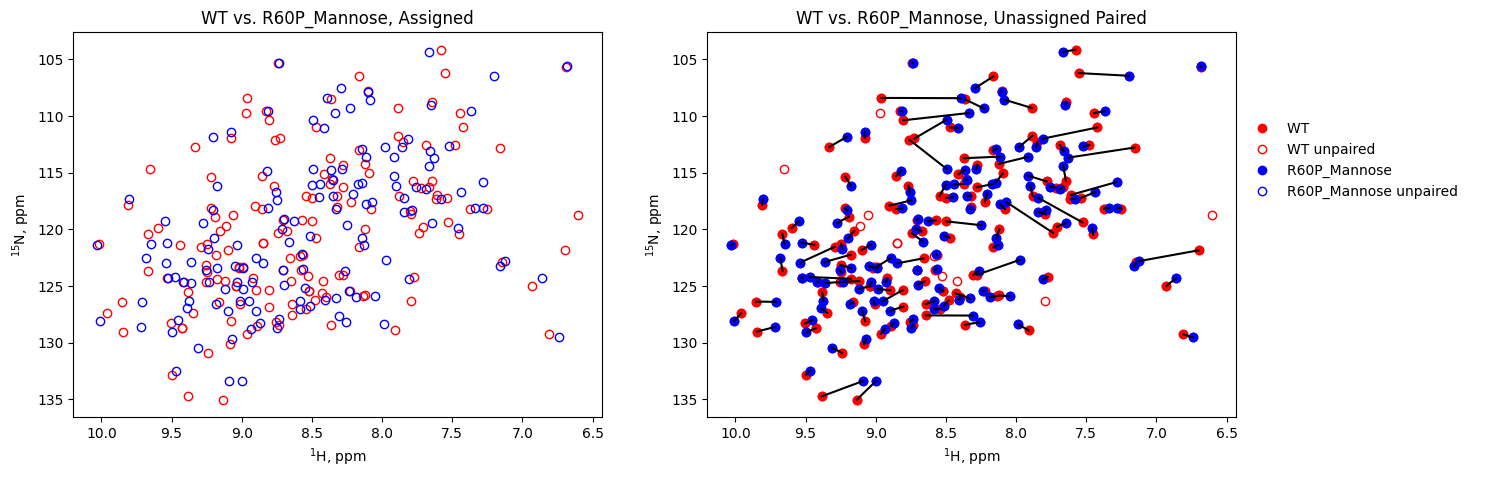

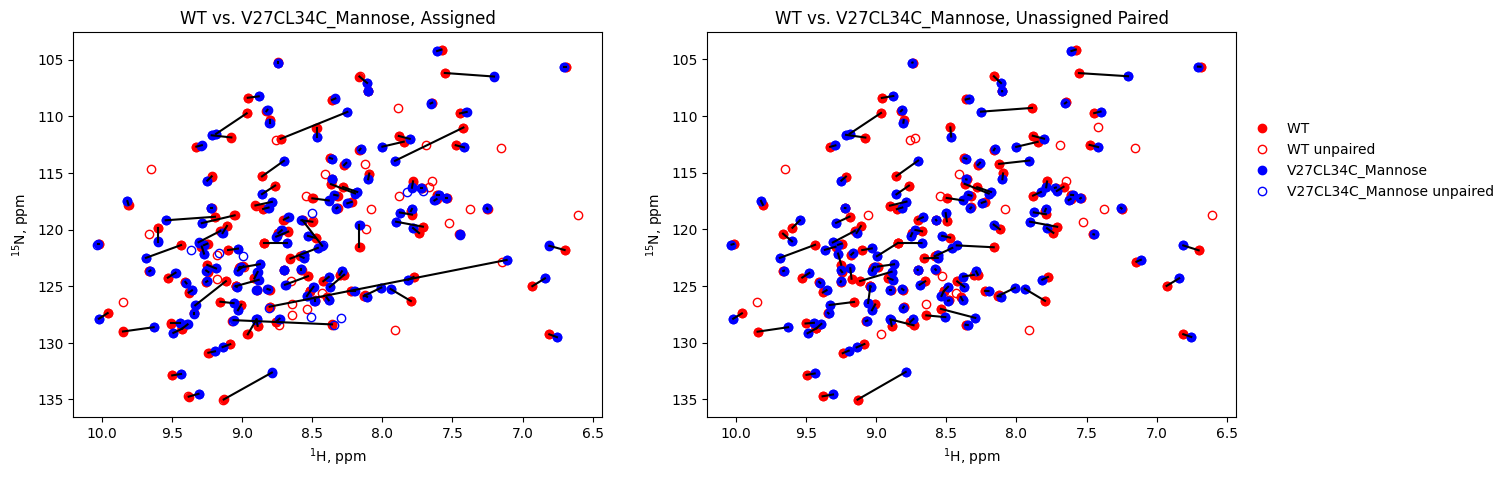

In [8]:
# Plot the spectra comparisons between two samples for assigned CSP and unassigned paired CSP

ref = 'WT'
label_max = len(max(samples, key=len))
ref_padding = ' '*(label_max-len(ref))

for compare in samples[1:]:
    comp_padding = ' '*(label_max-len(compare))
    comp_index = samp[ref].index(compare)
    Xrefa = all_csps[ref]['HN_0'].to_numpy(copy=True)  ## !!! Must use copy=True with .to_numpy(copy=True)
    Yrefa = all_csps[ref]['N_0'].to_numpy(copy=True)
    Xcompa = all_csps[ref]['HN_'+str(comp_index)].to_numpy(copy=True)
    Ycompa = all_csps[ref]['N_'+str(comp_index)].to_numpy(copy=True)


    Xrefa[np.argwhere(np.isnan(Xcompa))] = np.nan #needs to be in both
    Xcompa[np.argwhere(np.isnan(Xrefa))] = np.nan #

    Xrefall = X[ref].T[0]
    Xref = X[ref][row_ind[compare+'_vs_'+ref]].T[0]
    Xcompall = X[compare].T[0]
    Xcomp = X[compare][col_ind[compare+'_vs_'+ref]].T[0]
    Yrefall = X[ref].T[1]
    Yref = X[ref][row_ind[compare+'_vs_'+ref]].T[1]
    Ycompall = X[compare].T[1]
    Ycomp = X[compare][col_ind[compare+'_vs_'+ref]].T[1]

    fig, ax = plt.subplots(figsize=(15, 5), ncols=2, nrows = 1, squeeze=True,num=1,clear=True,)

    ax[0].plot(Xrefa,Yrefa,'ro',label=ref)
    ax[0].plot(Xrefall,Yrefall,'o',color='none',markerfacecolor=None,markeredgecolor='r')
    ax[0].plot(Xcompa,Ycompa,'bo',label=compare)
    ax[0].plot(Xcompall,Ycompall,'o',color='none',markerfacecolor=None,markeredgecolor='b')
    for i in range(min(len(Xrefa),len(Xcompa))):
        x_ref,y_ref = Xrefa[i],Yrefa[i]
        x_comp,y_comp = Xcompa[i],Ycompa[i]
        ax[0].plot([x_ref,x_comp],[y_ref,y_comp],'k-')
    ax[0].invert_xaxis()
    ax[0].invert_yaxis()
    ax[0].set_xlabel("$^1$H, ppm")
    ax[0].set_ylabel("$^{15}$N, ppm")
    ax[0].set_title(ref+" vs. "+compare+", Assigned")
    #ax[0].legend(loc='lower right');

    ax[1].plot(Xref,Yref,'ro',label=ref+ref_padding)
    #ax[1].plot(Xrefall,Yrefall,'ro',)#label=ref) #just for presentation plot

    ax[1].plot(Xrefall,Yrefall,'o',color='none',markerfacecolor=None,markeredgecolor='r',label=ref+" unpaired"+ref_padding)
    ax[1].plot(Xcomp,Ycomp,'bo',label=compare+comp_padding)
    #ax[1].plot(Xcompall,Ycompall,'bo',)#label=compare) #just for presentation plot
    ax[1].plot(Xcompall,Ycompall,'o',color='none',markerfacecolor=None,markeredgecolor='b',label=compare+" unpaired"+comp_padding)
    for i in range(min(len(Xref),len(Xcomp))):
        x_ref,y_ref = Xref[i],Yref[i]
        x_comp,y_comp = Xcomp[i],Ycomp[i]
        ax[1].plot([x_ref,x_comp],[y_ref,y_comp],'k-')
    ax[1].invert_xaxis()
    ax[1].invert_yaxis()
    ax[1].set_xlabel("$^1$H, ppm")
    ax[1].set_ylabel("$^{15}$N, ppm")
    ax[1].set_title(ref+" vs. "+compare+", Unassigned Paired")
    ax[1].legend(loc='upper left',bbox_to_anchor=(1,0.8),frameon=False);#loc='lower right',ncol=2);
    #fig.tight_layout()
    plt.show()
    #fig.savefig(os.path.join(project_dir,'FimHLD_pkmatch'+compare+'_vs_'+ref+'_'+date+'.pdf'),format='pdf',dpi=600,bbox_inches = 'tight')